In [5]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

from pylgmath import Transformation
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver, DoglegGaussNewtonSolver
from pysteam.evaluable import vspace as vspaceev, se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar

import scipy.interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_smoothing_spline

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [6]:
#import training dataset

dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl')

print(dataset)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0           0.0         0.0         0.0            0.0             0.0   
1           0.0         0.0         0.0            0.0             0.0   
2           0.0         0.0         0.0            0.0             0.0   
3           0.0         0.0         0.0            0.0             0.0   
4           0.0         0.0         0.0            0.0             0.0   
..          ...         ...         ...            ...             ...   
628         0.0         0.0         0.0            0.0             0.0   
629         0.0         0.0         0.0            0.0             0.0   
630         0.0         0.0         0.0            0.0             0.0   
631         0.0         0.0         0.0            0.0             0.0   
632         0.0         0.0         0.0            0.0             0.0   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0             0.0         0.0    0.0

In [14]:
# extract body_vel_distruptions arrays

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset[str_body_vel_disturption_yaw_list].to_numpy()

print(body_vel_disturption_x_array.flatten().shape)

(25320,)


Text(0, 0.5, 'Amount of steps')

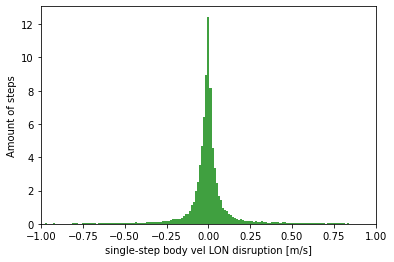

In [17]:
plt.hist(body_vel_disturption_x_array.flatten(), 500, density=True, facecolor='g', alpha=0.75)
plt.xlim(-1,1)
plt.xlabel('single-step body vel LON disruption [m/s]')
plt.ylabel('Amount of steps')

Text(0, 0.5, 'Amount of steps')

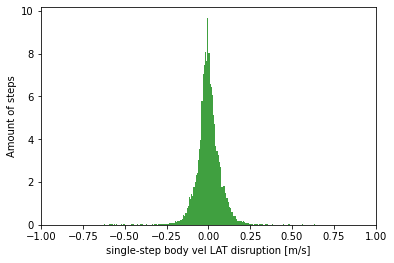

In [19]:
plt.hist(body_vel_disturption_y_array.flatten(), 500, density=True, facecolor='g', alpha=0.75)
plt.xlim(-1,1)
plt.xlabel('single-step body vel LAT disruption [m/s]')
plt.ylabel('Amount of steps')

Text(0, 0.5, 'Amount of steps')

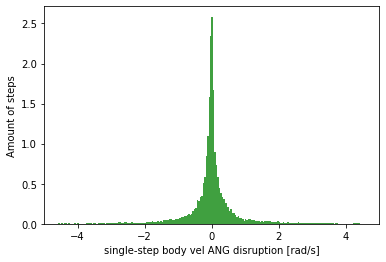

In [22]:
plt.hist(body_vel_disturption_yaw_array.flatten(), 5000, density=True, facecolor='g', alpha=0.75)
plt.xlim(-5,5)
plt.xlabel('single-step body vel ANG disruption [rad/s]')
plt.ylabel('Amount of steps')